In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
quals_data_file = pd.read_csv(r"../cleaned_data/f1db-races-qualifying-results-CLEANED.csv")
quals_data_file['min_time'] = quals_data_file[['timeMillis', 'q1Millis', 'q2Millis', 'q3Millis']].min(axis=1)
free_practice_1_data = pd.read_csv(r"../cleaned_data/f1db-races-free-practice-1-results-CLEANED.csv")
free_practice_2_data = pd.read_csv(r"../cleaned_data/f1db-races-free-practice-2-results-CLEANED.csv")
free_practice_3_data = pd.read_csv(r"../cleaned_data/f1db-races-free-practice-3-results-CLEANED.csv")
free_practice_4_data = pd.read_csv(r"../cleaned_data/f1db-races-free-practice-4-results-CLEANED.csv")
race_predictor_df = pd.read_csv(r"../Patrick/race_predictor_data.csv")
race_id_list = race_predictor_df['raceId'].unique()

In [3]:
pacedf = free_practice_1_data[['raceId', 'driverId', 'timeMillis']].rename(columns={'timeMillis': 'fp1Time'})

pacedf = pacedf.merge(
    free_practice_2_data[['raceId', 'driverId', 'timeMillis']].rename(columns={'timeMillis': 'fp2Time'}),
    on=['raceId', 'driverId'],
    how='left'
)

pacedf = pacedf.merge(
    free_practice_3_data[['raceId', 'driverId', 'timeMillis']].rename(columns={'timeMillis': 'fp3Time'}),
    on=['raceId', 'driverId'],
    how='left'
)

pacedf = pacedf.merge(
    quals_data_file[['raceId', 'driverId', 'timeMillis', 'q1Millis', 'q2Millis', 'q3Millis']].rename(columns={'timeMillis': 'qMillis'}),
    on=['raceId', 'driverId'],
    how='left'
)

pacedf['min_time'] = pacedf[['fp1Time', 'fp2Time', 'fp3Time', 'qMillis', 'q1Millis', 'q2Millis', 'q3Millis']].min(axis=1)
pacedf['min_time'] = pacedf['min_time'].fillna(1000000)
pacedf

,raceId,driverId,fp1Time,fp2Time,fp3Time,qMillis,q1Millis,q2Millis,q3Millis,min_time
0,435,nelson-piquet,78601.0,78353.0,NaN,77279.0,NaN,NaN,NaN,77279.0
1,435,ayrton-senna,78779.0,77977.0,NaN,76990.0,NaN,NaN,NaN,76990.0
2,435,gerhard-berger,79004.0,78088.0,NaN,77609.0,NaN,NaN,NaN,77609.0
3,435,keke-rosberg,79099.0,79160.0,NaN,79342.0,NaN,NaN,NaN,79099.0
4,435,nigel-mansell,79588.0,78785.0,NaN,77514.0,NaN,NaN,NaN,77514.0
...,...,...,...,...,...,...,...,...,...,...
14230,1125,fernando-alonso,85504.0,84574.0,84453.0,NaN,83794.0,83268.0,83196.0,83196.0
14231,1125,liam-lawson,85563.0,84503.0,84519.0,NaN,83733.0,83472.0,NaN,83472.0
14232,1125,valtteri-bottas,85611.0,84230.0,84479.0,NaN,83481.0,83341.0,83204.0,83204.0
14233,1125,guanyu-zhou,85921.0,84557.0,84668.0,NaN,83880.0,NaN,NaN,83880.0


In [6]:
fpdf = free_practice_1_data[['raceId', 'driverId', 'timeMillis']].rename(columns={'timeMillis': 'fp1Time'})

fpdf = fpdf.merge(
    free_practice_2_data[['raceId', 'driverId', 'timeMillis']].rename(columns={'timeMillis': 'fp2Time'}),
    on=['raceId', 'driverId'],
    how='left'
)

fpdf = fpdf.merge(
    free_practice_3_data[['raceId', 'driverId', 'timeMillis']].rename(columns={'timeMillis': 'fp3Time'}),
    on=['raceId', 'driverId'],
    how='left'
)

fpdf['min_time'] = fpdf[['fp1Time', 'fp2Time', 'fp3Time']].min(axis=1)
fpdf['min_time'] = fpdf['min_time'].fillna(1000000)

In [4]:
def new_time_open_ball(time, time_list, time_gap):        # Get sets of open balls with radius 1 second and basepoint each time
    new_open_ball = {time}

    for other_time in time_list:
        if abs(time - other_time) < time_gap: 
            new_open_ball.add(other_time)

    return new_open_ball

def get_clusters(set_of_times):                 # Generate all the clusters of times within 1 second of each other       
    time_clusters = []

    for set_1 in set_of_times:
        if len(time_clusters) > 0: 
            cluster_union = set.union(*time_clusters)
        else: 
            cluster_union = set()

        if set_1 & cluster_union: continue

        cluster = set_1
        for set_2 in set_of_times:
            if cluster & set_2:
                cluster = cluster | set_2
        time_clusters.append(cluster)

    return time_clusters

def sqmean_drivers_per_cluster(clusters_of_time, num_of_drivers):     # Gets squared mean number of drivers per cluster
    squared_mean = 0

    if num_of_drivers == 1: return squared_mean

    for cluster in clusters_of_time:
        num_of_drivers_in_cluster = len(cluster)
        squared_mean += num_of_drivers_in_cluster**2
    
    squared_mean = (squared_mean-num_of_drivers) / (num_of_drivers**2-num_of_drivers)

    return squared_mean

Max |Correlation| with ALPC: 0.2271 at time gap = 360 ms
Max |Correlation| with totalDNFs: -0.2542 at time gap = 380 ms


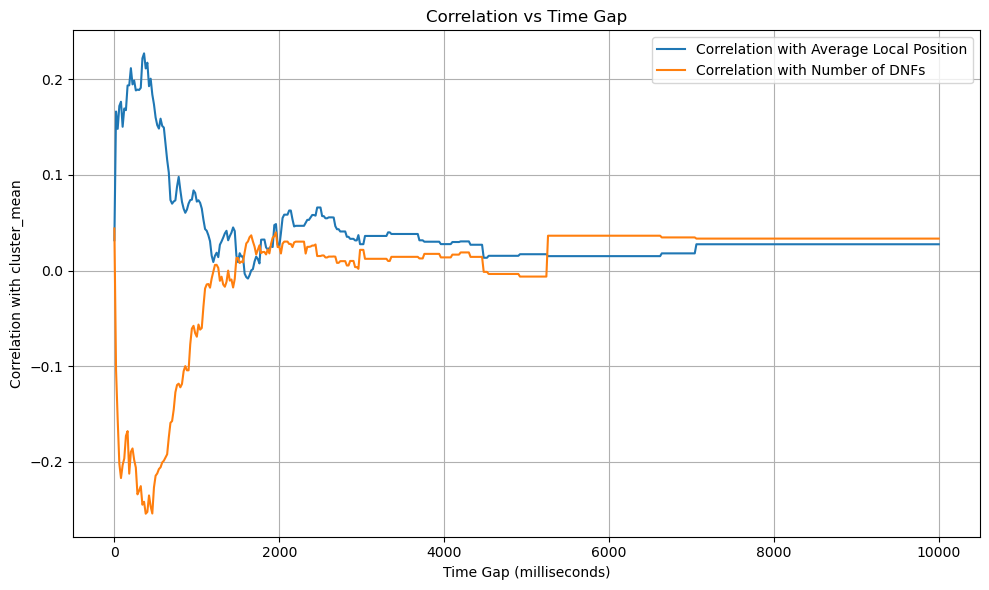

In [18]:
avg_local_pos_df = race_predictor_df[['raceId', 'ALPC']]
dnf_df = race_predictor_df[['raceId', 'totalDNFs']]

time_gaps = range(0, 10001, 20)
correlations_pos = []
correlations_dnf = []

for gap in time_gaps:
    cluster_sqmean = []

    for race_id in race_id_list:
        race_data = pacedf[pacedf['raceId'] == race_id]
        time_data = race_data['min_time'].to_list()
        if len(time_data) == 0: 
            cluster_sqmean.append({'raceId': race_id, 'cluster_mean': np.nan})
            continue

        time_sets = [new_time_open_ball(time, time_data, gap) for time in time_data]
        num_drivers = len(time_data)

        race_time_clusters = get_clusters(time_sets)
        cluster_sqmean.append({
            'raceId': race_id,
            'cluster_mean': sqmean_drivers_per_cluster(race_time_clusters, num_drivers)
        })

    cluster_df = pd.DataFrame(cluster_sqmean)

    # Merge with your external data
    merged = cluster_df.merge(avg_local_pos_df, on='raceId').merge(dnf_df, on='raceId')

    # Drop rows with NaNs
    merged_clean = merged.dropna()

    # Compute correlations
    corr_pos = merged_clean['cluster_mean'].corr(merged_clean['ALPC'])
    corr_dnf = merged_clean['cluster_mean'].corr(merged_clean['totalDNFs'])

    correlations_pos.append(corr_pos)
    correlations_dnf.append(corr_dnf)

# Find time gaps with largest absolute correlations
max_corr_pos = max(zip(time_gaps, correlations_pos), key=lambda x: abs(x[1]))
max_corr_dnf = max(zip(time_gaps, correlations_dnf), key=lambda x: abs(x[1]))

print(f"Max |Correlation| with ALPC: {max_corr_pos[1]:.4f} at time gap = {max_corr_pos[0]} ms")
print(f"Max |Correlation| with totalDNFs: {max_corr_dnf[1]:.4f} at time gap = {max_corr_dnf[0]} ms")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_gaps, correlations_pos, label='Correlation with Average Local Position')
plt.plot(time_gaps, correlations_dnf, label='Correlation with Number of DNFs')
plt.xlabel('Time Gap (milliseconds)')
plt.ylabel('Correlation with cluster_mean')
plt.title('Correlation vs Time Gap')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
